
# **Background**
Brain tumors pose a significant health challenge, where timely and precise detection is crucial for effective treatment and better patient prognosis. Magnetic Resonance Imaging (MRI) is a key tool for identifying brain abnormalities, yet manual analysis of MRI scans is labor-intensive, susceptible to errors, and demands expert knowledge. Convolutional Neural Networks (CNNs), a subset of artificial intelligence, provide a powerful means to automate and enhance the detection and classification of brain tumors, improving diagnostic speed and reliability.

# **Problem Statement**
This project aims to create an automated system using a CNN to detect and classify brain tumors from MRI scans into four categories: glioma, meningioma, pituitary, and no-tumor. The task involves designing a robust CNN model with TensorFlow, implemented in Google Colab, that can learn distinctive features from MRI images, manage variations in tumor presentation and image quality, and perform accurately on unseen data. The solution leverages a Kaggle dataset, requiring preprocessing and optimization to address real-world challenges like class imbalance and generalization.



# **Dataset**
The project utilizes the Brain Tumor MRI Dataset from Kaggle, consisting of 7033 grayscale MRI images, split as follows:

Training Set: 5712 images, organized into four class folders (glioma, meningioma, pituitary, notumor).
Testing Set: 1321 images, structured similarly. The images vary in resolution and quality, necessitating preprocessing steps such as resizing and normalization for consistent CNN input.
**1-Glioma:**

Gliomas are tumors originating from glial cells, the supportive cells around neurons in the brain. They range from low-grade (slow-growing) to high-grade (malignant, e.g., glioblastoma) and are the most common primary brain tumors. On MRI, they often appear irregular with varying contrast, influenced by grade and surrounding edema. Accurate detection is vital due to differing treatment needs.


**2-Meningioma:**

Meningiomas arise from the meninges, the protective layers covering the brain and spinal cord. Typically benign and slow-growing, some can become malignant or symptomatic due to pressure on brain structures. In MRI scans, they appear as well-defined, round masses with uniform contrast enhancement, aiding their identification for surgical or monitoring decisions.

**3-Pituitary:**

Pituitary tumors develop in the pituitary gland, which regulates hormones. Usually benign (e.g., pituitary adenomas), they can disrupt hormonal balance or affect vision by pressing on optic nerves. On MRI, they are located near the sella turcica and show distinct enhancement, making classification key for managing endocrine symptoms.

**4-No-tumor:**

This category includes MRI scans with no tumor or abnormal growth, serving as the control group. These images depict normal brain anatomy or minor non-tumor conditions (e.g., cysts). They lack the irregular masses or distortions seen in tumor cases, ensuring the CNN can differentiate healthy from pathological scans effectively.

Each category’s unique visual traits—shape, texture, intensity, and location—challenge the CNN to generalize across diverse tumor presentations and image qualities, enhancing its diagnostic potential.


# **1. Import Dataset:**

In [ ]:
!pip install opendatasets

In [ ]:
!pip install opencv-python

**To import data from kaggle: {"username":"sabalamea" , "key":"11deedf343baeafdd624fc00f359fd3d"}**

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jhg


# **2.Exploratory Data Analysis (EDA)/ Data Understanding :**

In [ ]:
#Import libraries

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import stats
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from tqdm import tqdm

In [ ]:
#import Training data
training_dir = "/content/brain-tumor-mri-dataset/Training"
if not os.path.exists(training_dir):
    raise FileNotFoundError(f"Directory not found: {training_dir}")

#import Testing data
testing_dir = "/content/brain-tumor-mri-dataset/Testing"
if not os.path.exists(testing_dir):
    raise FileNotFoundError(f"Directory not found: {testing_dir}")


In [ ]:
#Checking data structure

print("Checking Data Structure:")
train_classes = os.listdir(training_dir)
test_classes = os.listdir(testing_dir)

print("Train Classes:", train_classes)
print("Test Classes:", test_classes)

Checking Data Structure:
Train Classes: ['pituitary', 'notumor', 'glioma', 'meningioma']
Test Classes: ['pituitary', 'notumor', 'glioma', 'meningioma']


In [ ]:
# Count images per class
class_counts = {}
for cls in train_classes:
    class_path = os.path.join(training_dir, cls)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[f"train_{cls}"] = count

for cls in test_classes:
    class_path = os.path.join(testing_dir, cls)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[f"test_{cls}"] = count

print("Images per class:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count}")

Images per class:
  train_pituitary: 1457
  train_notumor: 1595
  train_glioma: 1321
  train_meningioma: 1339
  test_pituitary: 300
  test_notumor: 405
  test_glioma: 300
  test_meningioma: 306


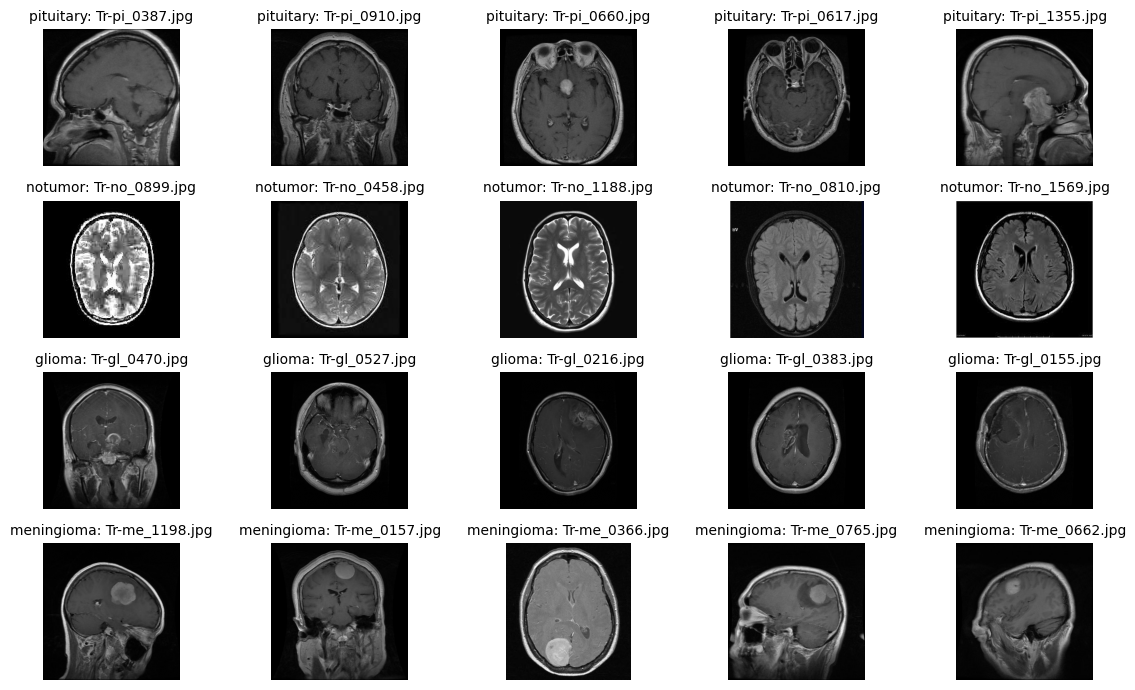

In [ ]:
# Visualize Data training (Display sample images)

plt.figure(figsize=(12, 7))
for i, cls in enumerate(train_classes):
    class_path = os.path.join(training_dir, cls)
    images = os.listdir(class_path)[:5]  # Get first 3 images

    for j, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = np.array(Image.open(img_path))

        plt.subplot(len(train_classes), 5, i*5 + j + 1)
        plt.imshow(img, cmap='gray') # we make sure all imgs in gray
        plt.title(f"{cls}: {img_name}", fontsize=10)  # Set a smaller font size here
        plt.axis('off')

plt.tight_layout()
plt.show()




Visualizing Sample Images:


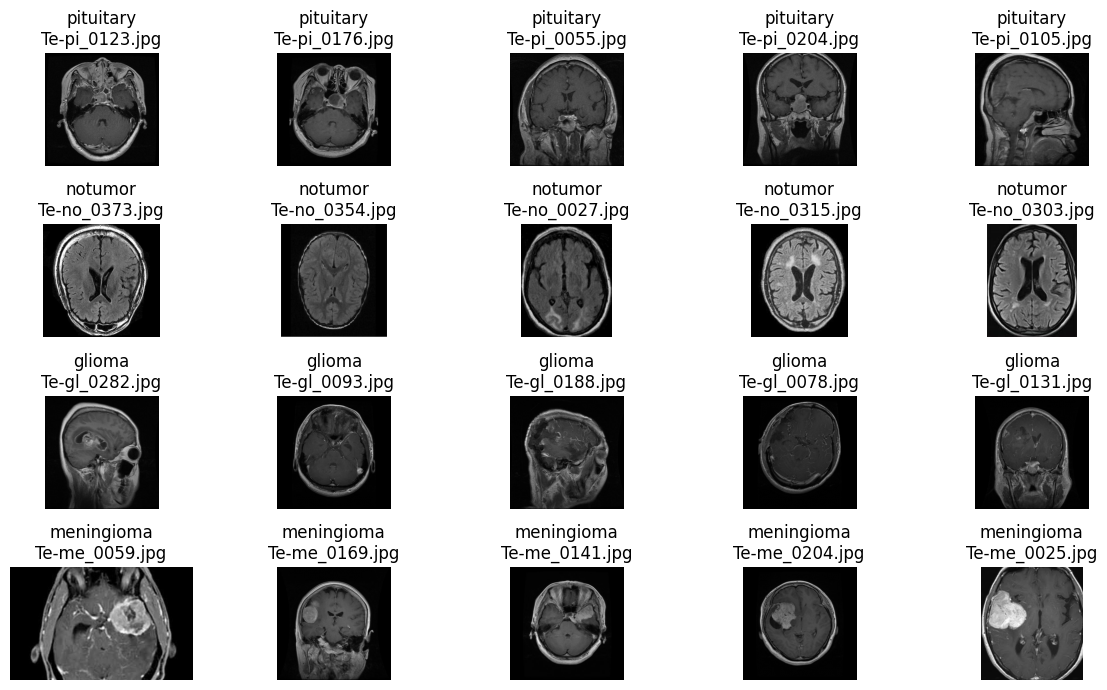

In [ ]:
# Visualize Data test (Display sample images)
print("\nVisualizing Sample Images:")
plt.figure(figsize=(12, 7))
for i, cls in enumerate(test_classes):
    cls_path = os.path.join(testing_dir , cls)
    images = os.listdir(cls_path)[:5]  # Display 5 images from each class
    for j, img_name in enumerate(images):
        img =  Image.open(os.path.join(cls_path, img_name))
        plt.subplot(len(test_classes), 5, i * 5 + j + 1)
        plt.imshow(img, cmap='gray')  # Display in grayscale
        plt.title(f"{cls}\n{img_name}")
        plt.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
# Check Image Trining Quality (Detect Corrupted Images)

print("Checking Image Quality:")
corrupted_images = []
for root, _, files in os.walk(training_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify if the image is not corrupted
        except Exception as e:
            corrupted_images.append(file_path)
            print(f"Corrupted Image: {file_path}")
if not corrupted_images:
    print("No corrupted images found.")

Checking Image Quality:
No corrupted images found.


In [ ]:
# Check Image testing Quality (Detect Corrupted Images)

print("Checking Image trining Quality:")
corrupted_images = []
for root, _, files in os.walk(testing_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify if the image is not corrupted
        except Exception as e:
            corrupted_images.append(file_path)
            print(f"Corrupted Image: {file_path}")
if not corrupted_images:
    print("No corrupted images found.")

Checking Image trining Quality:
No corrupted images found.


<ipython-input-12-004f3846af92>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


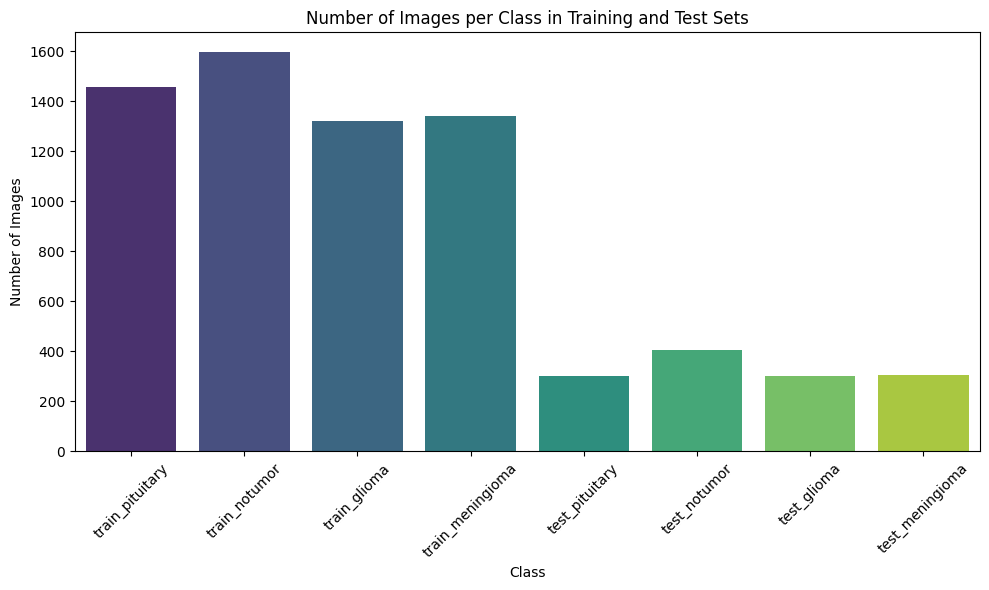

In [ ]:
# Calculate the distribution of images in each category.

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Number of Images per Class in Training and Test Sets")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

توزيع الصور عبر فئات مختلفة وتظهر أن البيانات غير متوازنة، مما قد يتطلب معالجة إضافية قبل استخدامها في تدريب نموذج تعلم الآلة (مثل استخدام تقنيات موازنة البيانات)

<ipython-input-13-d98b940e8827>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="Blues")


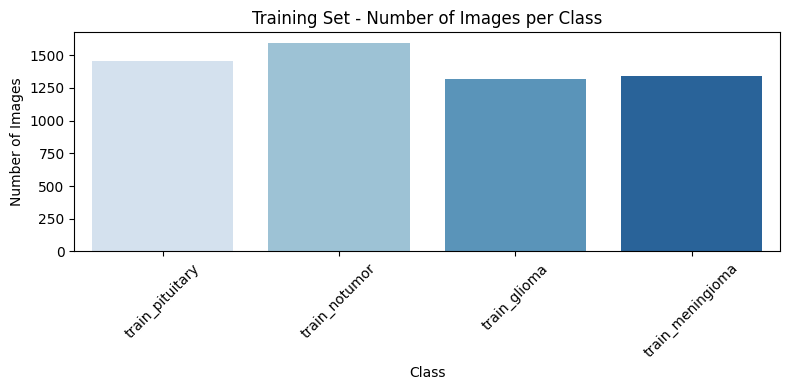

<ipython-input-13-d98b940e8827>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), palette="Oranges")


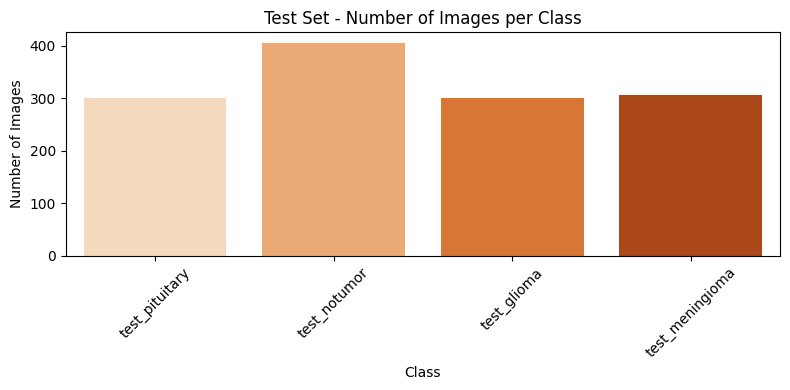

In [ ]:
# Separate the data into training and test
train_counts = {k: v for k, v in class_counts.items() if k.startswith('train')}
test_counts = {k: v for k, v in class_counts.items() if k.startswith('test')}

# Plot the training data
plt.figure(figsize=(8, 4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="Blues")
plt.title("Training Set - Number of Images per Class")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the test data
plt.figure(figsize=(8, 4))
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), palette="Oranges")
plt.title("Test Set - Number of Images per Class")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

labels = []
for cls in train_classes:
    class_path = os.path.join(training_dir, cls)
    for img_name in os.listdir(class_path):
        labels.append(cls)
TRclass_counts = Counter(labels)

labels = []
for cls in train_classes:
    class_path = os.path.join(testing_dir, cls)
    for img_name in os.listdir(class_path):
        labels.append(cls)
TSclass_counts = Counter(labels)

# تحويل القيم إلى مصفوفة
TRcounts = np.array(list(TRclass_counts.values()), dtype=np.float32)
TScounts = np.array(list(TSclass_counts.values()), dtype=np.float32)

# حساب الأوزان كعكس التكرار (inverse frequency)
TRweights = 1.0 / TRcounts
TSweights = 1.0 / TScounts

# تطبيع الأوزان (مجموعها = 1)
TRnormalized_weights = TRweights / TRweights.sum()
TSnormalized_weights = TSweights / TSweights.sum()

# طباعة الأوزان النهائية مع أسماء الفئات
print('Training weights:')
for cls, w in zip(TRclass_counts.keys(), TRnormalized_weights):
    print(f"Weight for class '{cls}': {w:.4f}")
print()
# طباعة الأوزان النهائية مع أسماء الفئات
print('Testing weights:')
for cls, w in zip(TSclass_counts.keys(), TSnormalized_weights):
    print(f"Weight for class '{cls}': {w:.4f}")

Training weights:
Weight for class 'pituitary': 0.2436
Weight for class 'notumor': 0.2226
Weight for class 'glioma': 0.2687
Weight for class 'meningioma': 0.2651

Testing weights:
Weight for class 'pituitary': 0.2687
Weight for class 'notumor': 0.1991
Weight for class 'glioma': 0.2687
Weight for class 'meningioma': 0.2635



Extracting Basic Statistics:
Average Image Size (Width, Height): [451.56320028 453.8837535 ]
Smallest Image Size: [150 168]
Largest Image Size: [1920 1446]


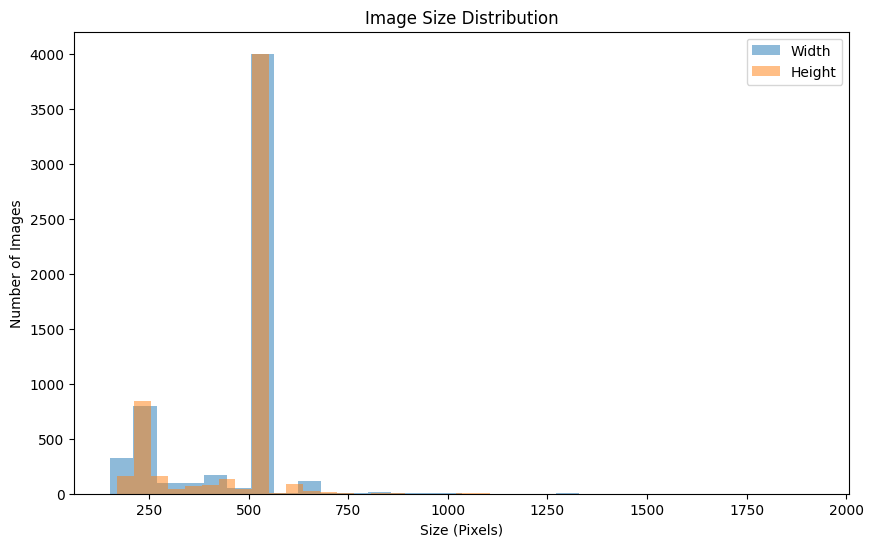

In [ ]:
#Extract Basic Statistics (Image Sizes)
print("\nExtracting Basic Statistics:")
sizes = []
for root, _, files in os.walk(training_dir):
    for file in files:
        file_path = os.path.join(root, file)
        img = Image.open(file_path)
        sizes.append(img.size)  # Image size (width, height)

# Convert the list to a numpy array
sizes = np.array(sizes)
print("Average Image Size (Width, Height):", np.mean(sizes, axis=0))
print("Smallest Image Size:", np.min(sizes, axis=0))
print("Largest Image Size:", np.max(sizes, axis=0))

# Plot the distribution of image sizes
plt.figure(figsize=(10, 6))
plt.hist(sizes[:, 0], bins=30, alpha=0.5, label="Width")
plt.hist(sizes[:, 1], bins=30, alpha=0.5, label="Height")
plt.title("Image Size Distribution")
plt.xlabel("Size (Pixels)")
plt.ylabel("Number of Images")
plt.legend()
plt.show()

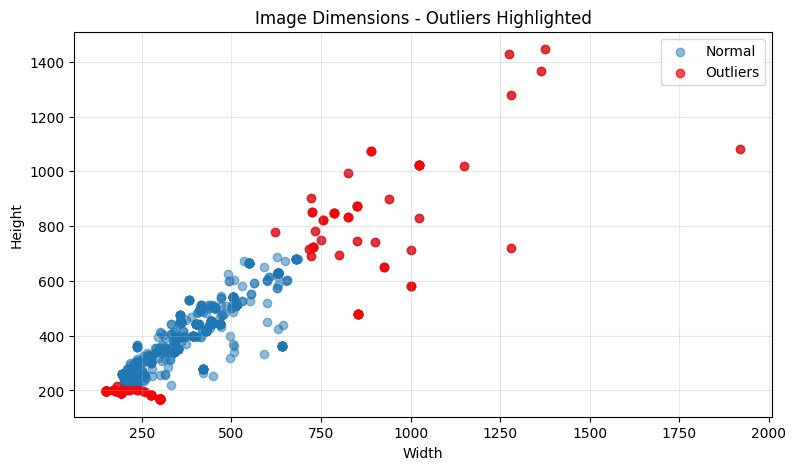

Found 205 outliers out of 5712 images


In [ ]:
# Identify outliers using z-scores
z_scores = stats.zscore(sizes)
outliers_mask = (np.abs(z_scores) > 2).any(axis=1)  # 2 is the best value bcos it gives you higher coverage and reveals photos that may be "imperfect".
outliers = sizes[outliers_mask]

# Create plot
plt.figure(figsize=(9, 5))
plt.scatter(sizes[:, 0], sizes[:, 1], alpha=0.5, label="Normal")
if len(outliers) > 0:  # Only plot outliers if they exist
    plt.scatter(outliers[:, 0], outliers[:, 1], color='red', alpha=0.7, label="Outliers")
plt.title("Image Dimensions - Outliers Highlighted")
plt.xlabel("Width"), plt.ylabel("Height")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Found {len(outliers)} outliers out of {len(sizes)} images")

# **preprocessing:**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import filters, morphology
from scipy import ndimage
import glob
from tqdm import tqdm
import tensorflow as tf
from sklearn.cluster import KMeans
from tensorflow.keras.preprocessing.image import ImageDataGenerator

✅ التعديلات التي أضفتها:
التعديل	الشرح
normalized_3ch = np.stack([normalized]*3, axis=-1)	تحويل الصورة من شكل (224,224) إلى (224,224,3)
استخدام normalized_3ch في الحفظ	لضمان التوافق مع نماذج مثل DenseNet وResNet
اسم الصورة المحفوظة *_rgb.jpg	لتوضيح أنها نسخة بثلاث قنوات



Processing Training/pituitary:   0%|          | 0/1457 [00:00<?, ?it/s]

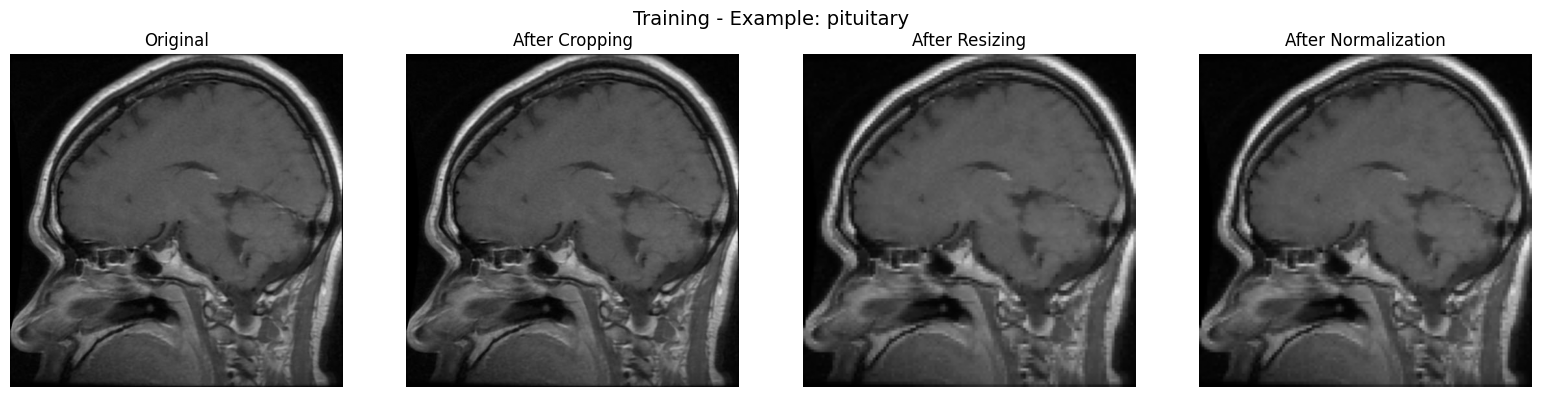

Processing Training/notumor:   0%|          | 0/1595 [00:00<?, ?it/s]

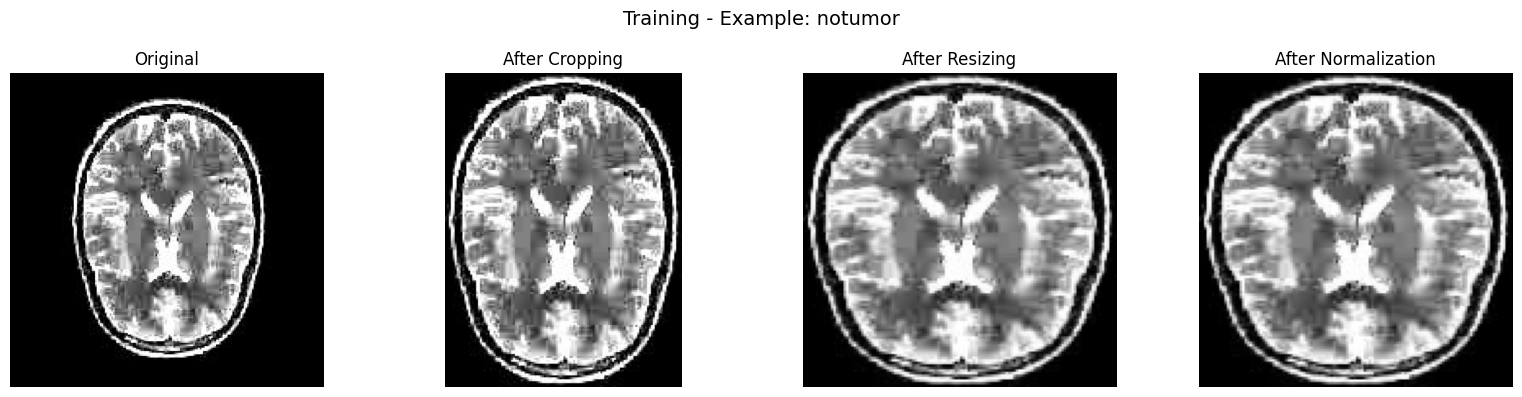

Processing Training/glioma:   0%|          | 0/1321 [00:00<?, ?it/s]

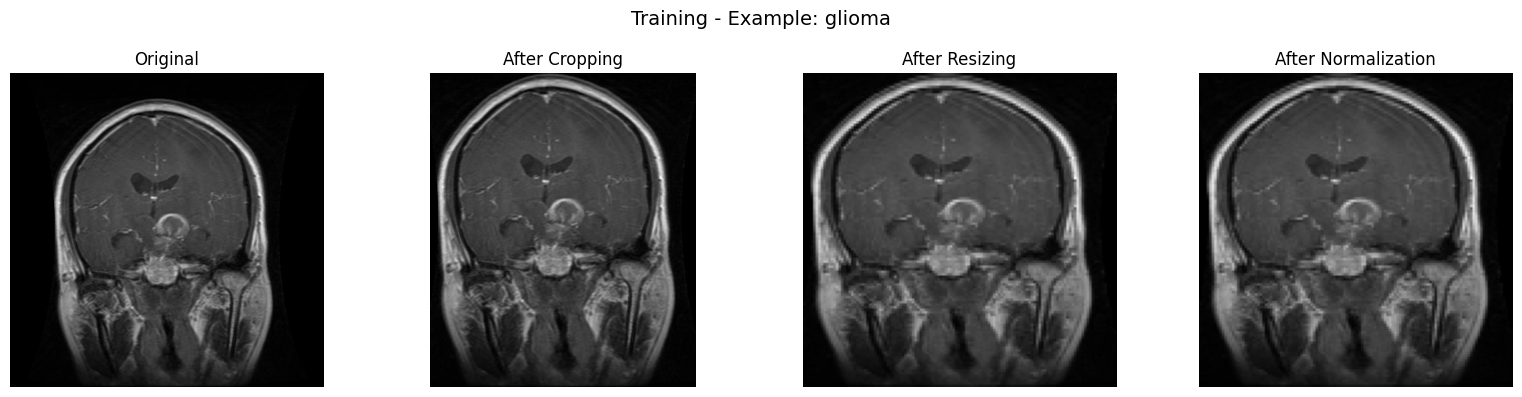

Processing Training/meningioma:   0%|          | 0/1339 [00:00<?, ?it/s]

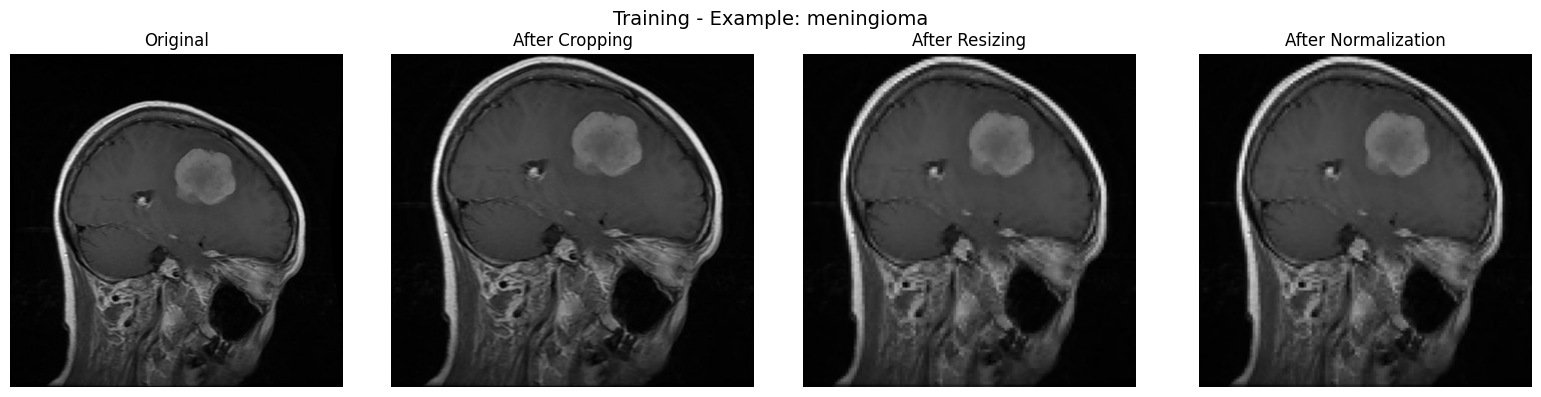

Processing Training/meningioma: 100%|██████████| 1339/1339 [00:06<00:00, 199.72it/s]



✅ Training معالجة وانتهت. الصور في '/content/processed_Training_data/' والبيانات في CSV.



Processing Testing/meningioma: 100%|██████████| 306/306 [00:00<00:00, 474.16it/s]


✅ Testing معالجة وانتهت. الصور في '/content/processed_Testing_data/' والبيانات في CSV.



In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

original_data_dir = "/content/brain-tumor-mri-dataset"
output_base_dir = "/content"

img_size = (124, 124)

# دالة لقص الدماغ
def crop_brain_contour(image):
    _, thresh = cv2.threshold(image, 5, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    return image[y:y+h, x:x+w]

# دالة المعالجة العامة لمجموعة بيانات (تدريب أو اختبار)
def process_dataset(subset_name, show_examples=False):
    subset_dir = os.path.join(original_data_dir, subset_name)
    processed_dir = os.path.join(output_base_dir, f"processed_{subset_name}_data")
    os.makedirs(processed_dir, exist_ok=True)

    data_records = []

    for class_name in os.listdir(subset_dir):
        class_dir = os.path.join(subset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        dest_class_dir = os.path.join(processed_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)

        shown_example = False

        for filename in tqdm(os.listdir(class_dir), desc=f"Processing {subset_name}/{class_name}"):
            img_path = os.path.join(class_dir, filename)

            original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if original is None:
                continue

            cropped = crop_brain_contour(original)
            resized = cv2.resize(cropped, img_size)
            normalized = resized.astype('float32') / 255.0

            # ⬅️ تحويل إلى 3 قنوات (رمادي مكرر)
            normalized_3ch = np.stack([normalized]*3, axis=-1)

            # حفظ الصورة المعالجة
            base_name = os.path.splitext(filename)[0]
            save_path = os.path.join(dest_class_dir, f"{base_name}_rgb.jpg")
            cv2.imwrite(save_path, (normalized_3ch * 255).astype('uint8'))

            data_records.append([save_path, class_name])

            # عرض مثال واحد فقط لكل صنف
            if show_examples and not shown_example:
                fig, axes = plt.subplots(1, 4, figsize=(16, 4))

                axes[0].imshow(original, cmap='gray')
                axes[0].set_title("Original")
                axes[0].axis('off')

                axes[1].imshow(cropped, cmap='gray')
                axes[1].set_title("After Cropping")
                axes[1].axis('off')

                axes[2].imshow(resized, cmap='gray')
                axes[2].set_title("After Resizing")
                axes[2].axis('off')

                axes[3].imshow(normalized, cmap='gray')
                axes[3].set_title("After Normalization")
                axes[3].axis('off')

                plt.suptitle(f"{subset_name} - Example: {class_name}", fontsize=14)
                plt.tight_layout()
                plt.show()

                shown_example = True

    # حفظ ملف CSV
    df = pd.DataFrame(data_records, columns=["image_path", "label"])
    df.to_csv(os.path.join(processed_dir, "images_with_labels.csv"), index=False)
    print(f"\n✅ {subset_name} معالجة وانتهت. الصور في '{processed_dir}/' والبيانات في CSV.\n")

# معالجة مجموعة التدريب مع العرض
process_dataset("Training", show_examples=True)

# معالجة مجموعة الاختبار بدون العرض
process_dataset("Testing", show_examples=False)


النموذج يتعلم بشكل أفضل Normalization يساعد على:

تقليل الانحرافات الكبيرة في القيم.

تسريع التقارب أثناء التدريب.

منع بعض المشاكل مثل vanishing/exploding gradients.

In [ ]:
'''from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Use 20% for validation

train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(original_data_dir, 'Training'),
    target_size=img_size,  # Resize images
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Specify training subset
)

val_generator = train_datagen.flow_from_directory(
    directory=os.path.join(original_data_dir, 'Training'),
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify validation subset
)


# Assuming you have a separate test set directory
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(original_data_dir, 'Testing'),
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)
'''

"from tensorflow.keras.preprocessing.image import ImageDataGenerator\n\n# Set up ImageDataGenerator for training and validation\ntrain_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Use 20% for validation\n\ntrain_generator = train_datagen.flow_from_directory(\n    directory=os.path.join(original_data_dir, 'Training'),\n    target_size=img_size,  # Resize images\n    batch_size=32,\n    class_mode='categorical',\n    subset='training'  # Specify training subset\n)\n\nval_generator = train_datagen.flow_from_directory(\n    directory=os.path.join(original_data_dir, 'Training'),\n    target_size=img_size,\n    batch_size=32,\n    class_mode='categorical',\n    subset='validation'  # Specify validation subset\n)\n\n\n# Assuming you have a separate test set directory\ntest_datagen = ImageDataGenerator(rescale=1./255)\ntest_generator = test_datagen.flow_from_directory(\n    directory=os.path.join(original_data_dir, 'Testing'),\n    target_size=img_size,\n    batch_size

In [ ]:
'''
# Assign X_train, X_val, y_train, y_val from the Generator

# Collect training data into arrays
X_train, y_train = [], []
for _ in range(len(train_generator)):
    images, labels = next(train_generator)
    X_train.append(images)
    y_train.append(labels)

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Collect validation data into arrays
X_val, y_val = [], []
for _ in range(len(val_generator)):
    images, labels = next(val_generator)
    X_val.append(images)
    y_val.append(labels)

X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)
'''

'\n# Assign X_train, X_val, y_train, y_val from the Generator\n\n# Collect training data into arrays\nX_train, y_train = [], []\nfor _ in range(len(train_generator)):\n    images, labels = next(train_generator)\n    X_train.append(images)\n    y_train.append(labels)\n\nX_train = np.concatenate(X_train, axis=0)\ny_train = np.concatenate(y_train, axis=0)\n\n# Collect validation data into arrays\nX_val, y_val = [], []\nfor _ in range(len(val_generator)):\n    images, labels = next(val_generator)\n    X_val.append(images)\n    y_val.append(labels)\n\nX_val = np.concatenate(X_val, axis=0)\ny_val = np.concatenate(y_val, axis=0)\n'

In [ ]:
'''
# Define class names
classes = list(train_generator.class_indices.keys())

# Load and preprocess data from the generator
X_train, y_train = next(train_generator)
X_val, y_val = next(val_generator)

print(f"Input image shape: {X_train.shape}")
'''

'\n# Define class names\nclasses = list(train_generator.class_indices.keys())\n\n# Load and preprocess data from the generator\nX_train, y_train = next(train_generator)\nX_val, y_val = next(val_generator)\n\nprint(f"Input image shape: {X_train.shape}")\n'

In [ ]:
'''
# Take one batch of data from the image generator
images, labels = next(train_generator)

# Take the first image from the batch
normal_array = images[0] * 255  # Convert back to original scale for proper display
resized_array = cv2.resize(normal_array, img_size)  # Resize image for visualization
normalized_array = images[0]     # Values are normalized between 0-1

# Display info and statistics
print(f"Original Image - Shape: {normal_array.shape}")
print(f"Original Image - Min: {normal_array.min()}, Max: {normal_array.max()}")
print(f"Resized Image - Min: {resized_array.min()}, Max: {resized_array.max()}")
print(f"Normalized Image - Min: {normalized_array.min():.2f}, Max: {normalized_array.max():.2f}")
print(f"Normalized Image - Mean: {normalized_array.mean():.2f}, Std: {normalized_array.std():.2f}")

# Show images in three stages: Normal, Resized, and Normalized
plt.figure(figsize=(12, 4))

# Normal Image
plt.subplot(1, 3, 1)
plt.imshow(normal_array.astype('uint8'))
plt.title("Normal Image")
plt.axis('off')

# Resized Image
plt.subplot(1, 3, 2)
plt.imshow(resized_array.astype('uint8'))
plt.title("Resized Image")
plt.axis('off')

# Normalized Image
plt.subplot(1, 3, 3)
plt.imshow(normalized_array)
plt.title("Normalized Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# Pixel value histograms
plt.figure(figsize=(12, 4))

# Histogram for Normal Image
plt.subplot(1, 3, 1)
plt.hist(normal_array.flatten(), bins=50, alpha=0.7)
plt.title("Original Image Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

# Histogram for Resized Image
plt.subplot(1, 3, 2)
plt.hist(resized_array.flatten(), bins=50, alpha=0.7)
plt.title("Resized Image Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

# Histogram for Normalized Image
plt.subplot(1, 3, 3)
plt.hist(normalized_array.flatten(), bins=50, alpha=0.7)
plt.title("Normalized Image Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
'''

'\n# Take one batch of data from the image generator\nimages, labels = next(train_generator)\n\n# Take the first image from the batch\nnormal_array = images[0] * 255  # Convert back to original scale for proper display\nresized_array = cv2.resize(normal_array, img_size)  # Resize image for visualization\nnormalized_array = images[0]     # Values are normalized between 0-1\n\n# Display info and statistics\nprint(f"Original Image - Shape: {normal_array.shape}")\nprint(f"Original Image - Min: {normal_array.min()}, Max: {normal_array.max()}")\nprint(f"Resized Image - Min: {resized_array.min()}, Max: {resized_array.max()}")\nprint(f"Normalized Image - Min: {normalized_array.min():.2f}, Max: {normalized_array.max():.2f}")\nprint(f"Normalized Image - Mean: {normalized_array.mean():.2f}, Std: {normalized_array.std():.2f}")\n\n# Show images in three stages: Normal, Resized, and Normalized\nplt.figure(figsize=(12, 4))\n\n# Normal Image\nplt.subplot(1, 3, 1)\nplt.imshow(normal_array.astype(\'uint

# **Modeling(CNN) :**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from tensorflow.keras.regularizers import l2
import cv2

In [ ]:
# إعداد المتغيرات الأساسية
target_size = (128, 128)
IMG_SIZE = target_size
num_classes = 4
batch_size = 16
epochs = 100
random_seed = 42

resized_train_path = "/content/processed_Training_data"
images = []
all_labels = []

# قراءة التصنيفات (المجلدات)
classes = [d for d in os.listdir(resized_train_path) if os.path.isdir(os.path.join(resized_train_path, d))]

# تحميل الصور وتحويلها إلى grayscale
for idx, cls in enumerate(classes):
    class_path = os.path.join(resized_train_path, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0
            images.append(img)
            all_labels.append(idx)

# تحويل الصور والتصنيفات إلى مصفوفات NumPy
images = np.array(images)
all_labels = np.array(all_labels)
labels_one_hot = to_categorical(all_labels, num_classes=len(classes))


In [ ]:
# تقسيم البيانات إلى تدريب + اختبار مؤقتًا بنسبة 80% تدريب و 20% اختبار
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels_one_hot, test_size=0.2, random_state=random_seed, stratify=labels_one_hot
)

# من بيانات التدريب المؤقتة، ناخذ 20% كتحقق (validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=random_seed, stratify=y_temp
)


In [ ]:
# Build a custom CNN model from scratch
model = models.Sequential([
    # Input layer and first convolutional layer
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fourth convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Dropout layer to prevent overfitting
    layers.Dropout(0.3),

    # Flatten the data before fully connected layers
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,197,572 (8.38 MB)

 Trainable params: 2,196,580 (8.38 MB)

 Non-trainable params: 992 (3.88 KB)

In [ ]:
# Define callbacks to improve training
callbacks_list = [
    # Save the best model
    callbacks.ModelCheckpoint(
        filepath='best_brain_tumor_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    # Reduce learning rate if the validation loss stops improving
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    # Early stopping to prevent overfitting
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )
]


In [ ]:

# Initialize a dictionary to store the training history for later visualization
history_dict = {
    'accuracy': [],         # Store training accuracy
    'val_accuracy': [],     # Store validation accuracy
    'loss': [],             # Store training loss
    'val_loss': []          # Store validation loss
}


In [ ]:
# Loop through each epoch for training
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train the model for one epoch
    history = model.fit(
        x=X_train,                # Training data (features)
        y=y_train,                # Training data (labels)
        batch_size=16,    # Batch size
        epochs=1,                 # Only 1 epoch at a time
        validation_data=(X_val, y_val),   # Validation data for evaluation
        callbacks=callbacks_list,        # List of callbacks for early stopping, saving the best model, etc.
        verbose=1                          # Print progress during training
    )

    # Evaluate the model on validation data after each epoch
    val_loss, val_accuracy = model.evaluate(X_val, y_val)  # Evaluate using validation data
    print(f"Model Accuracy on Validation Data: {val_accuracy:.4f}")

    # Store the results in the history dictionary
    history_dict['accuracy'].extend(history.history['accuracy'])  # Training accuracy
    history_dict['val_accuracy'].extend(history.history['val_accuracy'])  # Validation accuracy
    history_dict['loss'].extend(history.history['loss'])  # Training loss
    history_dict['val_loss'].extend(history.history['val_loss'])  # Validation loss


Epoch 1/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6831 - loss: 0.9307
Epoch 1: val_accuracy improved from -inf to 0.25492, saving model to best_brain_tumor_model.h5


229/229 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.6834 - loss: 0.9298 - val_accuracy: 0.2549 - val_loss: 7.6717 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2536 - loss: 7.7428
Model Accuracy on Validation Data: 0.2549
Epoch 2/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8368 - loss: 0.4620
Epoch 1: val_accuracy improved from 0.25492 to 0.48031, saving model to best_brain_tumor_model.h5


229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8368 - loss: 0.4620 - val_accuracy: 0.4803 - val_loss: 1.7497 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4893 - loss: 1.7577
Model Accuracy on Validation Data: 0.4803
Epoch 3/100
223/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8872 - loss: 0.3216
Epoch 1: val_accuracy improved from 0.48031 to 0.86980, saving model to best_brain_tumor_model.h5


229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8873 - loss: 0.3219 - val_accuracy: 0.8698 - val_loss: 0.3784 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8670 - loss: 0.3514
Model Accuracy on Validation Data: 0.8698
Epoch 4/100
222/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8944 - loss: 0.3177
Epoch 1: val_accuracy improved from 0.86980 to 0.90591, saving model to best_brain_tumor_model.h5


229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8944 - loss: 0.3177 - val_accuracy: 0.9059 - val_loss: 0.2887 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9142 - loss: 0.2634
Model Accuracy on Validation Data: 0.9059
Epoch 5/100
226/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9217 - loss: 0.2287
Epoch 1: val_accuracy did not improve from 0.90591
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9217 - loss: 0.2290 - val_accuracy: 0.9015 - val_loss: 0.3249 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9143 - loss: 0.3044
Model Accuracy on Validation Data: 0.9015
Epoch 6/100
224/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9252 - loss: 0.2249
Epoch 1: val_accuracy did not improve from 0.90591
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9253 - loss: 0.2248 - val_accuracy: 0.

229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9431 - loss: 0.1828 - val_accuracy: 0.9234 - val_loss: 0.2345 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9327 - loss: 0.2043
Model Accuracy on Validation Data: 0.9234
Epoch 8/100
225/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9608 - loss: 0.1430
Epoch 1: val_accuracy did not improve from 0.92341
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9606 - loss: 0.1434 - val_accuracy: 0.8709 - val_loss: 0.3633 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8786 - loss: 0.3659
Model Accuracy on Validation Data: 0.8709
Epoch 9/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9650 - loss: 0.1271
Epoch 1: val_accuracy did not improve from 0.92341
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9649 - loss: 0.1272 - val_accuracy: 0.

229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9639 - loss: 0.1191 - val_accuracy: 0.9344 - val_loss: 0.1958 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9513 - loss: 0.1619
Model Accuracy on Validation Data: 0.9344
Epoch 13/100
225/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9737 - loss: 0.0959
Epoch 1: val_accuracy did not improve from 0.93435
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9737 - loss: 0.0960 - val_accuracy: 0.9289 - val_loss: 0.2202 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9398 - loss: 0.2058
Model Accuracy on Validation Data: 0.9289
Epoch 14/100
224/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9498 - loss: 0.1515
Epoch 1: val_accuracy did not improve from 0.93435
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9500 - loss: 0.1511 - val_accuracy: 

229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9665 - loss: 0.1302 - val_accuracy: 0.9420 - val_loss: 0.1760 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9518 - loss: 0.1582
Model Accuracy on Validation Data: 0.9420
Epoch 16/100
226/229 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9631 - loss: 0.1217
Epoch 1: val_accuracy did not improve from 0.94201
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9631 - loss: 0.1215 - val_accuracy: 0.9125 - val_loss: 0.2711 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9170 - loss: 0.2417
Model Accuracy on Validation Data: 0.9125
Epoch 17/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9843 - loss: 0.0630
Epoch 1: val_accuracy did not improve from 0.94201
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9843 - loss: 0.0630 - val_accuracy:

229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9922 - loss: 0.0389 - val_accuracy: 0.9551 - val_loss: 0.1703 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9545 - loss: 0.1426
Model Accuracy on Validation Data: 0.9551
Epoch 34/100
223/229 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9891 - loss: 0.0476
Epoch 1: val_accuracy did not improve from 0.95514
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9890 - loss: 0.0481 - val_accuracy: 0.9059 - val_loss: 0.2989 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9222 - loss: 0.2460
Model Accuracy on Validation Data: 0.9059
Epoch 35/100
223/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9837 - loss: 0.0646
Epoch 1: val_accuracy did not improve from 0.95514
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9835 - loss: 0.0653 - val_accuracy:

229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9862 - loss: 0.0525 - val_accuracy: 0.9617 - val_loss: 0.2171 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9684 - loss: 0.1669
Model Accuracy on Validation Data: 0.9617
Epoch 88/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9921 - loss: 0.0394
Epoch 1: val_accuracy did not improve from 0.96171
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9921 - loss: 0.0394 - val_accuracy: 0.9573 - val_loss: 0.2364 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9664 - loss: 0.1678
Model Accuracy on Validation Data: 0.9573
Epoch 89/100
227/229 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9944 - loss: 0.0289
Epoch 1: val_accuracy did not improve from 0.96171
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9944 - loss: 0.0290 - val_accuracy:

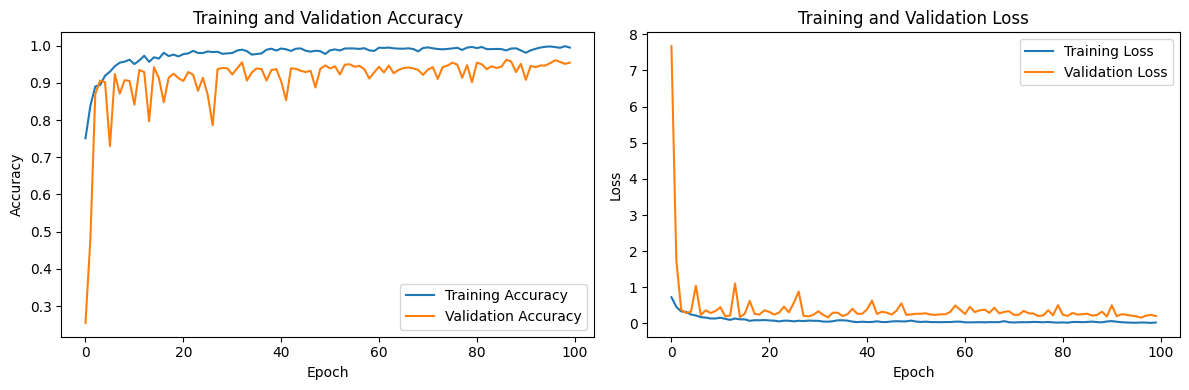

In [ ]:
# Create a figure for plotting learning curves
plt.figure(figsize=(12, 4))

# Subplot for accuracy: training vs validation
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.xlabel('Epoch')  # Label for X-axis
plt.ylabel('Accuracy')  # Label for Y-axis
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.legend()  # Display the legend

# Subplot for loss: training vs validation
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')  # Plot training loss
plt.plot(history_dict['val_loss'], label='Validation Loss')  # Plot validation loss
plt.xlabel('Epoch')  # Label for X-axis
plt.ylabel('Loss')  # Label for Y-axis
plt.title('Training and Validation Loss')  # Title of the plot
plt.legend()  # Display the legend

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Save the plot as an image file
plt.savefig('learning_curves.png')

# Display the plot
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


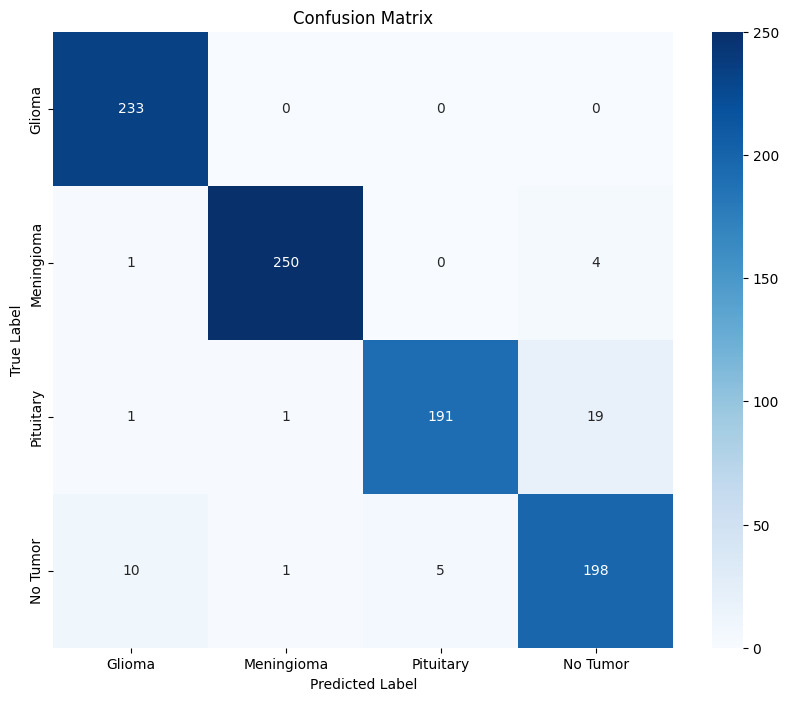

In [ ]:
# Get model predictions
y_pred = model.predict(X_val)  # Predict the class labels for the validation set
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels (highest probability)
y_true = np.argmax(y_val, axis=1)  # Convert true labels from one-hot encoding to class labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)  # Calculate the confusion matrix

# Define the class names
class_names = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']  # List of class labels

# Display the confusion matrix
plt.figure(figsize=(10, 8))  # Set the figure size for the plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',  # Create a heatmap of the confusion matrix
            xticklabels=class_names,  # Set the x-axis labels (predicted labels)
            yticklabels=class_names)  # Set the y-axis labels (true labels)
plt.xlabel('Predicted Label')  # Label for the x-axis
plt.ylabel('True Label')  # Label for the y-axis
plt.title('Confusion Matrix')  # Title for the plot
plt.savefig('confusion_matrix.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

In [ ]:
# عرض تقرير التصنيف
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

      Glioma       0.95      1.00      0.97       233
  Meningioma       0.99      0.98      0.99       255
   Pituitary       0.97      0.90      0.94       212
    No Tumor       0.90      0.93      0.91       214

    accuracy                           0.95       914
   macro avg       0.95      0.95      0.95       914
weighted avg       0.96      0.95      0.95       914



In [ ]:
model.save('brain_tumor_classification_model.h5')


In [ ]:
# تقييم النموذج على بيانات الاختبار
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9348 - loss: 0.4013
Test Accuracy: 0.9484
Test Loss: 0.3312


# **Modeling(VGG) :**

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 393ms/step - accuracy: 0.3051 - loss: 3.3492 - val_accuracy: 0.4819 - val_loss: 2.2386 - learning_rate: 1.0000e-05
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 243ms/step - accuracy: 0.5171 - loss: 2.3805 - val_accuracy: 0.5895 - val_loss: 1.9593 - learning_rate: 1.0000e-05
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 243ms/step - accuracy: 0.6282 - loss: 2.0579 - val_accuracy: 0.6690 - val_loss: 1.7940 - learning_rate: 1.0000e-05
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 243ms/step - accuracy: 0.6915 - loss: 1.8473 - val_accuracy: 0.6749 - val_loss: 1.8447 - learning_rate: 1.0000e-05
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - accuracy: 0.7495 - loss: 1.6970 - val_accuracy: 0.7544 - val_loss: 1.6178 - learning_rate: 1.0000e-05
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.7681 - loss: 1.6060 - val_accuracy: 0.7801 - val_loss: 1.6462 - learning_rate: 1.0000e-05
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 24

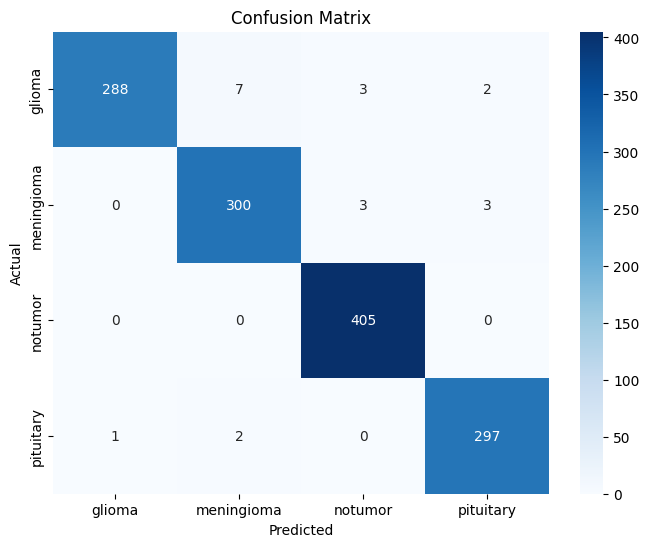


Classification Report:
               precision    recall  f1-score   support

      glioma     0.9965    0.9600    0.9779       300
  meningioma     0.9709    0.9804    0.9756       306
     notumor     0.9854    1.0000    0.9926       405
   pituitary     0.9834    0.9900    0.9867       300

    accuracy                         0.9840      1311
   macro avg     0.9841    0.9826    0.9832      1311
weighted avg     0.9841    0.9840    0.9839      1311

Accuracy:  0.9840
Precision: 0.9841
Recall:    0.9840
F1 Score:  0.9839


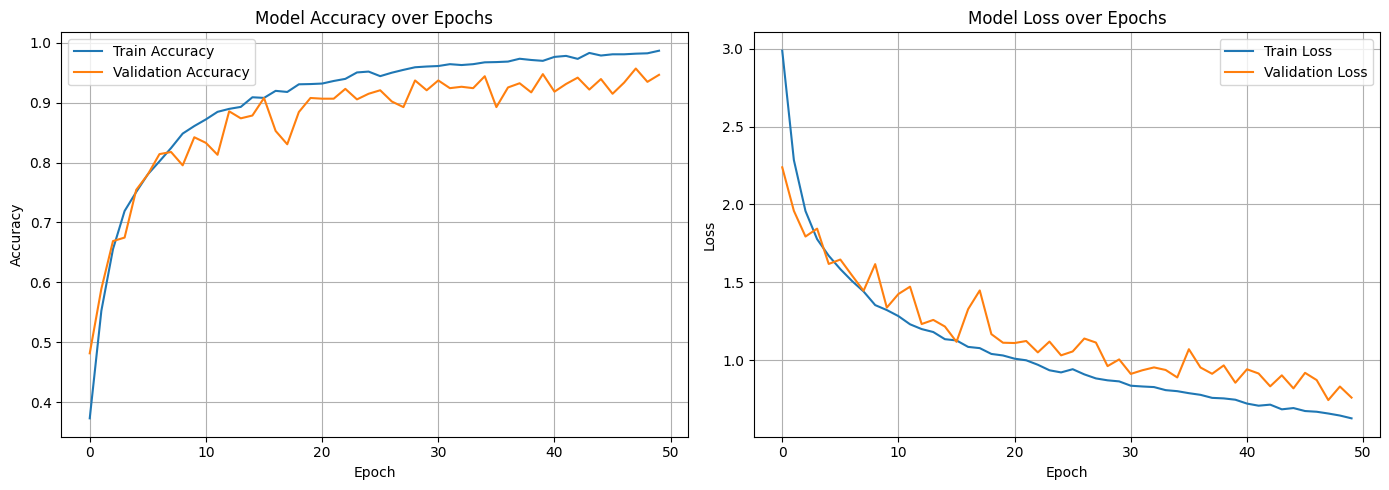

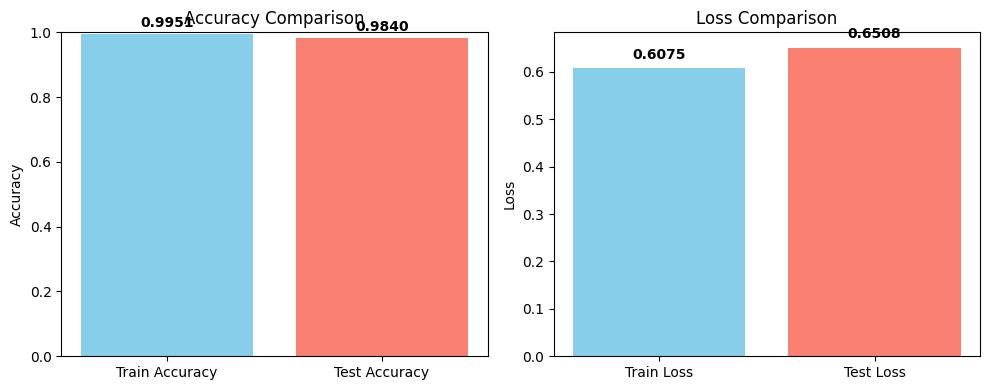

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks impor+t EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# --- Image size ---
IMG_SIZE = (124, 124)

# --- Enhanced Data Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=[0.8, 1.2],
    channel_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/processed_Training_data',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    '/content/processed_Training_data',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    '/content/processed_Testing_data',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# --- Load VGG16 base ---
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(124, 124, 3))

# Freeze more layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# --- Custom Head with Regularization and BatchNorm ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.002))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.002))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# --- Compile ---
optimizer = Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7)

# --- Train ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stop, reduce_lr]
)

# --- Evaluate Test Set ---
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
train_loss, train_acc = model.evaluate(train_generator, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}, Test Loss:  {test_loss:.4f}")

# --- Predict and report ---
test_generator.reset()
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)
true_class_indices = test_generator.classes
labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_class_indices, predicted_class_indices)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_class_indices, predicted_class_indices, target_names=labels, digits=4)
print("\nClassification Report:\n", report)

precision = precision_score(true_class_indices, predicted_class_indices, average='weighted')
recall = recall_score(true_class_indices, predicted_class_indices, average='weighted')
f1 = f1_score(true_class_indices, predicted_class_indices, average='weighted')
accuracy = accuracy_score(true_class_indices, predicted_class_indices)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# --- Accuracy & Loss over Epochs ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# --- Bar Chart Comparison: Train vs Test ---
plt.figure(figsize=(10, 4))

# Accuracy bar
plt.subplot(1, 2, 1)
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
for i, v in enumerate([train_acc, test_acc]):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

# Loss bar
plt.subplot(1, 2, 2)
plt.bar(['Train Loss', 'Test Loss'], [train_loss, test_loss], color=['skyblue', 'salmon'])
plt.title('Loss Comparison')
plt.ylabel('Loss')
for i, v in enumerate([train_loss, test_loss]):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()



🔍 Image from class: glioma
📷 Image name: Te-gl_0199_rgb.jpg
✅ Predicted class: glioma
🔢 Confidence: 99.98%
📊 Class probabilities:
  glioma: 99.98%
  meningioma: 0.01%
  notumor: 0.00%
  pituitary: 0.01%


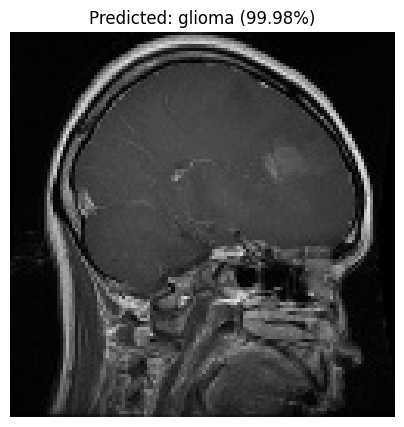


🔍 Image from class: meningioma
📷 Image name: Te-me_0107_rgb.jpg
✅ Predicted class: meningioma
🔢 Confidence: 99.90%
📊 Class probabilities:
  glioma: 0.00%
  meningioma: 99.90%
  notumor: 0.09%
  pituitary: 0.01%


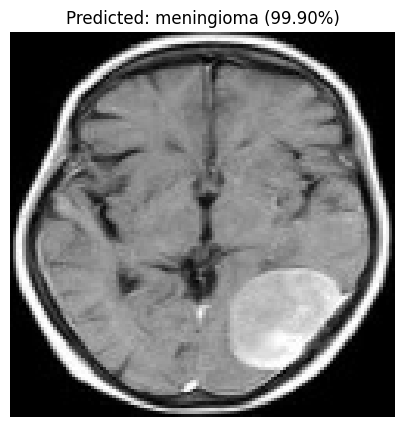


🔍 Image from class: notumor
📷 Image name: Te-no_0136_rgb.jpg
✅ Predicted class: notumor
🔢 Confidence: 100.00%
📊 Class probabilities:
  glioma: 0.00%
  meningioma: 0.00%
  notumor: 100.00%
  pituitary: 0.00%


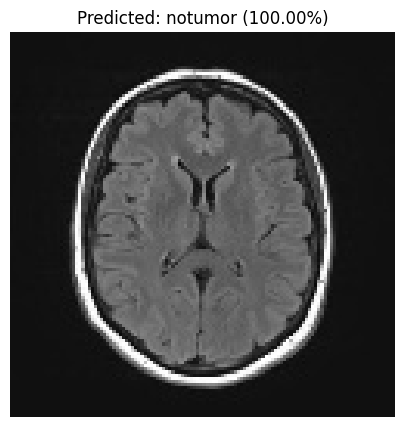


🔍 Image from class: pituitary
📷 Image name: Te-pi_0153_rgb.jpg
✅ Predicted class: pituitary
🔢 Confidence: 100.00%
📊 Class probabilities:
  glioma: 0.00%
  meningioma: 0.00%
  notumor: 0.00%
  pituitary: 100.00%


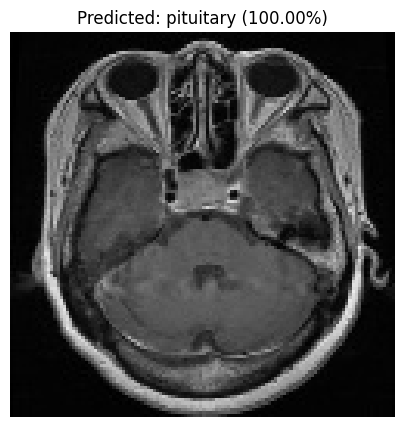

In [ ]:
import os
import glob
from tensorflow.keras.preprocessing import image

# --- Path to the structured test data ---
norm_test_path = '/content/processed_Testing_data'

# --- Target class names (matching test folders) ---
target_classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# --- Predict one image from each class ---
for class_name in target_classes:
    # Get list of JPG images in the class folder
    image_paths = glob.glob(os.path.join(norm_test_path, class_name, '*.jpg'))

    if image_paths:
        image_path = image_paths[0]  # Use the first image found

        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(124, 124))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0  # Normalize

        # Make prediction using the trained model
        predictions = model.predict(x, verbose=0)
        predicted_index = np.argmax(predictions)
        predicted_class = list(train_generator.class_indices.keys())[predicted_index]
        confidence = predictions[0][predicted_index]

        # Print prediction details
        print(f"\n🔍 Image from class: {class_name}")
        print(f"📷 Image name: {os.path.basename(image_path)}")
        print(f"✅ Predicted class: {predicted_class}")
        print(f"🔢 Confidence: {confidence:.2%}")
        print("📊 Class probabilities:")
        for label, index in train_generator.class_indices.items():
            print(f"  {label}: {predictions[0][index]:.2%}")

        # Display the image with prediction
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class} ({confidence:.2%})")
        plt.axis('off')
        plt.show()
    else:
        print(f"⚠️ No JPG images found in: {os.path.join(norm_test_path, class_name)}")


In [ ]:
model.save("my_vgg_model.h5")


# **Modeling(MobileNet V2) :**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


In [ ]:
# Augmentation + validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training and Validation Generators
train_generator = train_datagen.flow_from_directory(
    '/content/processed_Training_data',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    '/content/processed_Training_data',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Testing Generator
test_generator = test_datagen.flow_from_directory(
    '/content/processed_Testing_data',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 148s 752ms/step - accuracy: 0.6680 - loss: 1.2517 - val_accuracy: 0.5469 - val_loss: 2.0081 - learning_rate: 1.0000e-04
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 104s 729ms/step - accuracy: 0.8749 - loss: 0.7442 - val_accuracy: 0.5285 - val_loss: 2.4127 - learning_rate: 1.0000e-04
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 707ms/step - accuracy: 0.9055 - loss: 0.6633 - val_accuracy: 0.5881 - val_loss: 2.0164 - learning_rate: 1.0000e-04
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9304 - loss: 0.5979
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
143/143 ━━━━━━━━━━━━━━━━━━━━ 104s 728ms/step - accuracy: 0.9304 - loss: 0.5979 - val_accuracy: 0.5907 - val_loss: 2.1857 - learning_rate: 1.0000e-04
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 139s 704ms/step - accuracy: 0.9393 - loss

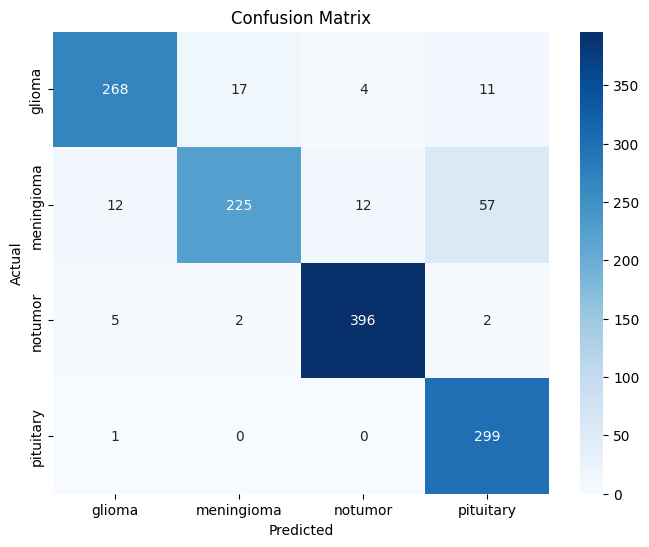


Classification Report:
               precision    recall  f1-score   support

      glioma     0.9371    0.8933    0.9147       300
  meningioma     0.9221    0.7353    0.8182       306
     notumor     0.9612    0.9778    0.9694       405
   pituitary     0.8103    0.9967    0.8939       300

    accuracy                         0.9062      1311
   macro avg     0.9077    0.9008    0.8990      1311
weighted avg     0.9120    0.9062    0.9043      1311

Accuracy:  0.9062
Precision: 0.9120
Recall:    0.9062
F1 Score:  0.9043


In [ ]:
# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Fine-tune last few layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile model
optimizer = Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stop, reduce_lr]
)

# Evaluation & prediction
test_generator.reset()
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)
true_class_indices = test_generator.classes
labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(true_class_indices, predicted_class_indices, target_names=labels, digits=4)
print("\nClassification Report:\n", report)

precision = precision_score(true_class_indices, predicted_class_indices, average='weighted')
recall = recall_score(true_class_indices, predicted_class_indices, average='weighted')
f1 = f1_score(true_class_indices, predicted_class_indices, average='weighted')
accuracy = accuracy_score(true_class_indices, predicted_class_indices)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

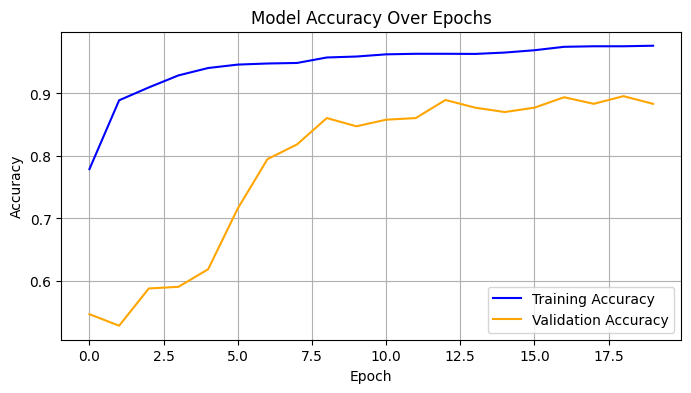

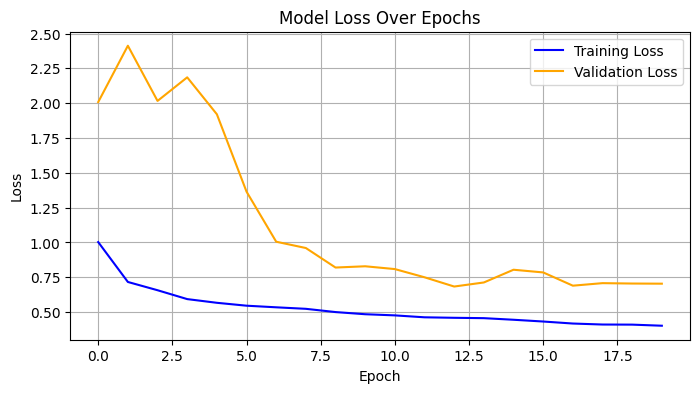

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# تقييم النموذج على بيانات الاختبار
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 415ms/step - accuracy: 0.8744 - loss: 0.7657

Test Accuracy: 0.9062
Test Loss: 0.6785


41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 357ms/step - accuracy: 0.8744 - loss: 0.7657


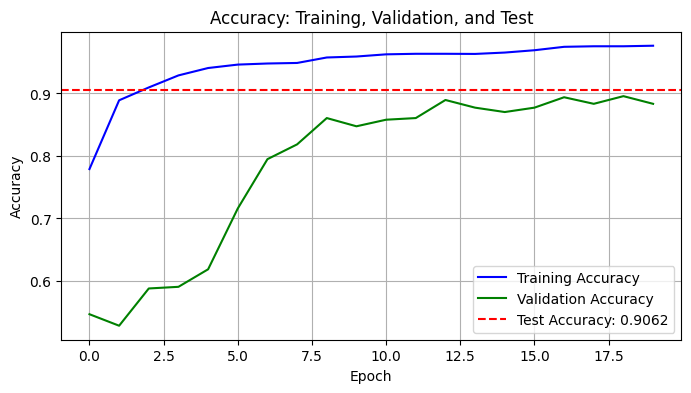

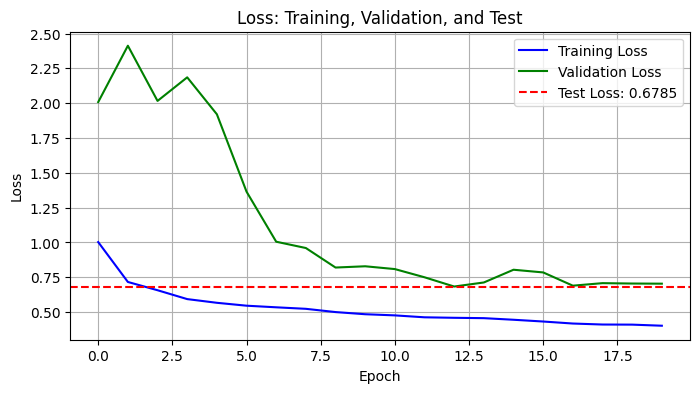

In [ ]:
import matplotlib.pyplot as plt

# تقييم الأداء على بيانات الاختبار
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

# ====== الرسم البياني للدقة ======
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.axhline(y=test_acc, color='red', linestyle='--', label=f'Test Accuracy: {test_acc:.4f}')
plt.title('Accuracy: Training, Validation, and Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ====== الرسم البياني للخسارة ======
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.axhline(y=test_loss, color='red', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.title('Loss: Training, Validation, and Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# **Modeling (ResNet50) :**

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define image size, batch size, and other parameters
image_size = (124, 124)
target_size=image_size
batch_size = 32
num_classes = 4
input_shape = (124, 124, 3)
epoch = 60
lr = 0.001

In [ ]:
 # Data directories (assuming you've already set these up)
norm_train_path = "/content/processed_Training_data"
norm_test_path = "/content/processed_Testing_data"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Set up ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, rotation_range=15)  # Use 20% for validation



# Create training dataset
train_generator = train_datagen.flow_from_directory(
    norm_train_path,
    target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

# Create validation dataset (without data augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_generator = validation_datagen.flow_from_directory(
    norm_train_path,
    target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle= False,
    seed= 42
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    norm_test_path,
    target_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)



Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

In [ ]:
# List to store trained models
trained_models = []

# Models to train
from tensorflow.keras.applications import ResNet50
models_to_train = [
    ('ResNet50', ResNet50(weights='imagenet', include_top=False, input_shape=input_shape))
]

# Loop through models to train instead of using functions
for name, base_model in models_to_train:
    display(HTML(f'<h3>{name}</h3>'))
    display(HTML(''))

    # Create the model (previously in createModel function)
    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,719,108 (90.48 MB)

 Trainable params: 23,665,988 (90.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# List to store trained models
trained_models = []

# Models to train
from tensorflow.keras.applications import ResNet50
models_to_train = [
    ('ResNet50', ResNet50(weights='imagenet', include_top=False, input_shape=input_shape))
]

# Loop through models to train instead of using functions
for name, base_model in models_to_train:
    display(HTML(f'<h3>{name}</h3>'))
    display(HTML(''))

    # Create the model (previously in createModel function)
    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train the model (previously in trainModel function)
    history = model.fit(
        train_generator,
        epochs=epoch,
        validation_data=validation_generator,
        callbacks=callbacks,
        verbose=1
    )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,719,108 (90.48 MB)

 Trainable params: 23,665,988 (90.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 132s 430ms/step - accuracy: 0.6944 - loss: 1.0202 - val_accuracy: 0.2340 - val_loss: 1.8999 - learning_rate: 0.0010
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.8902 - loss: 0.4628 - val_accuracy: 0.2314 - val_loss: 14.7860 - learning_rate: 0.0010
Epoch 3/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.9189 - loss: 0.3611 - val_accuracy: 0.2314 - val_loss: 1.6282 - learning_rate: 0.0010
Epoch 4/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.9275 - loss: 0.3093 - val_accuracy: 0.2550 - val_loss: 8.4922 - learning_rate: 0.0010
Epoch 5/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.9364 - loss: 0.2808 - val_accuracy: 0.2410 - val_loss: 11.5396 - learning_rate: 0.0010
Epoch 6/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - accuracy: 0.9596 - loss: 0.1981 - val_accuracy: 0.5329 - val_loss: 1.6363 - learning_rate: 0.0010
Epoch 7/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 

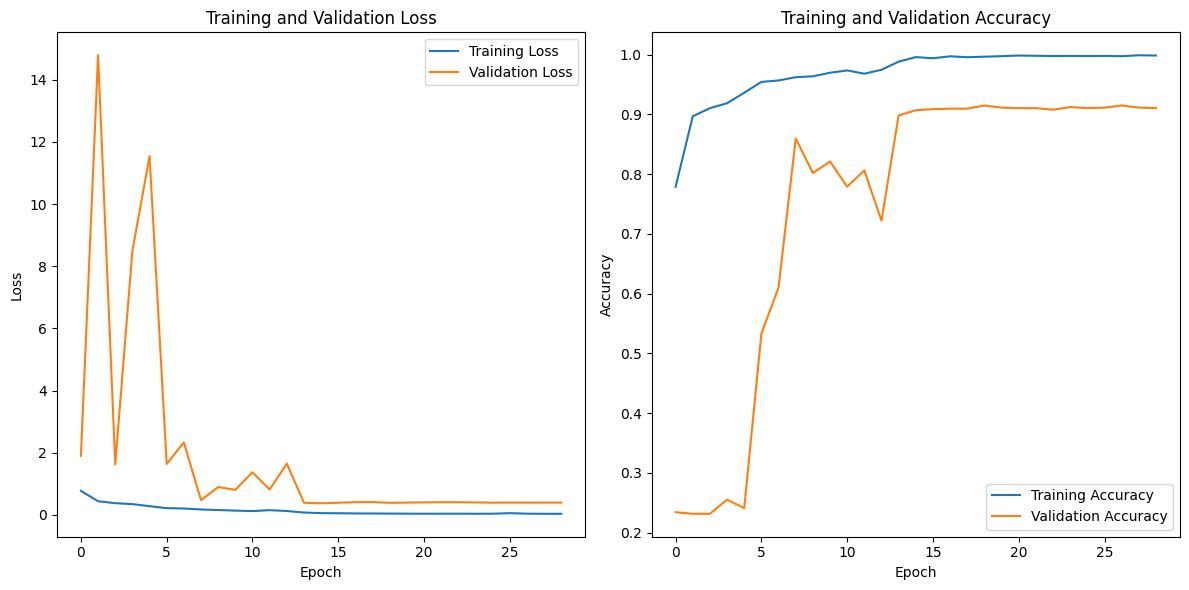

In [ ]:
  # Plot training history (previously in historyPlot function)
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

    # Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step


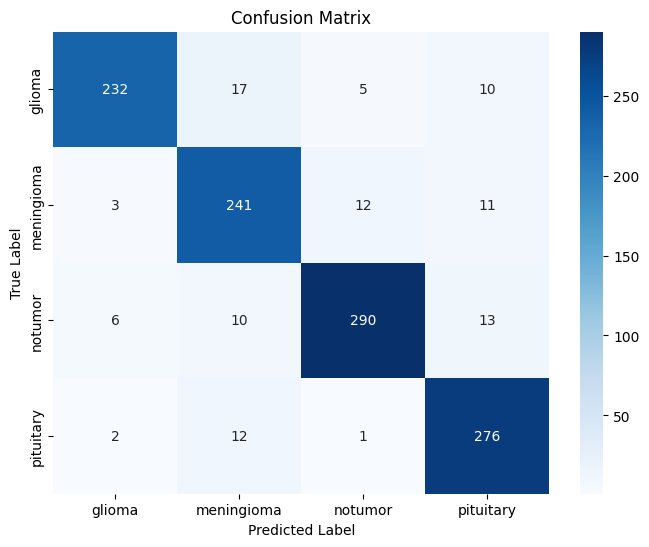

Classification Report:
               precision    recall  f1-score   support

      glioma       0.95      0.88      0.92       264
  meningioma       0.86      0.90      0.88       267
     notumor       0.94      0.91      0.93       319
   pituitary       0.89      0.95      0.92       291

    accuracy                           0.91      1141
   macro avg       0.91      0.91      0.91      1141
weighted avg       0.91      0.91      0.91      1141



In [ ]:
# Evaluate on validation data (previously in evaluate function)
y_pred = model.predict(validation_generator).argmax(axis=1)
y_true = validation_generator.classes

class_labels = list(validation_generator.class_indices.keys())

conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

display(HTML('<hr>'))

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

display(HTML(''))

In [ ]:
  # Store the trained model and name
trained_models.append((name, model))


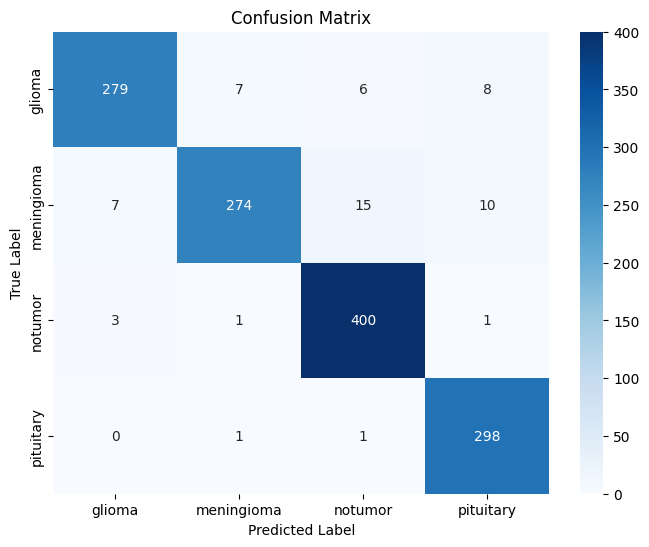

Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.97      0.90      0.93       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.94      0.99      0.97       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [ ]:
# Evaluate models on test data
results = []

for name, model in trained_models:
    # Evaluate on test data (previously in evaluate_on_test function)
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator, verbose=0)
    y_pred = y_pred_probs.argmax(axis=1)

    class_labels = list(test_generator.class_indices.keys())

    conf_mat = confusion_matrix(y_true, y_pred)

    display(HTML(f'<h2>{name}</h2>'))
    display(HTML('<hr>'))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

     # Classification report
    display(HTML('<hr>'))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))
    display(HTML('<hr>'))

In [ ]:
 # Calculate metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
display(HTML(f'<h2>Model</h2>'))
display(HTML('<hr>'))
display(results_df)

,Model,Accuracy,Precision,Recall,F1 Score
0,ResNet50,0.954233,0.954838,0.954233,0.953834


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Predicting sample glioma image: Te-gl_0062_rgb.jpg

Prediction: glioma
Confidence: 100.00%
Class probabilities:
  glioma: 100.00%
  meningioma: 0.00%
  notumor: 0.00%
  pituitary: 0.00%


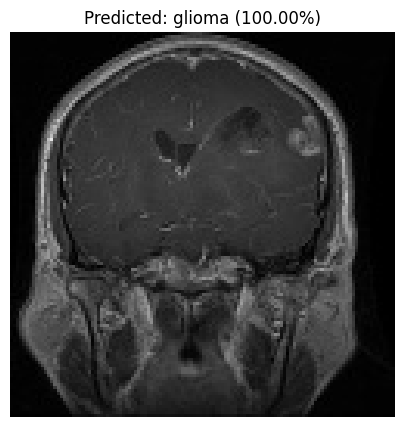

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Predicting sample meningioma image: Te-me_0302_rgb.jpg

Prediction: meningioma
Confidence: 100.00%
Class probabilities:
  glioma: 0.00%
  meningioma: 100.00%
  notumor: 0.00%
  pituitary: 0.00%


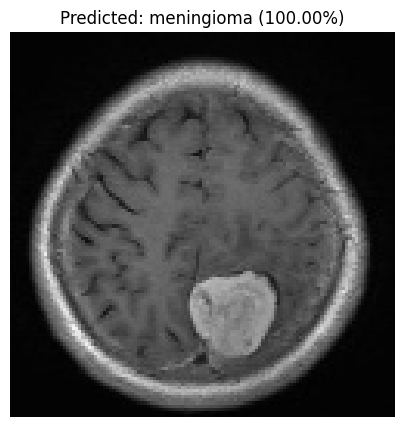

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Predicting sample notumor image: Te-no_0012_rgb.jpg

Prediction: notumor
Confidence: 100.00%
Class probabilities:
  glioma: 0.00%
  meningioma: 0.00%
  notumor: 100.00%
  pituitary: 0.00%


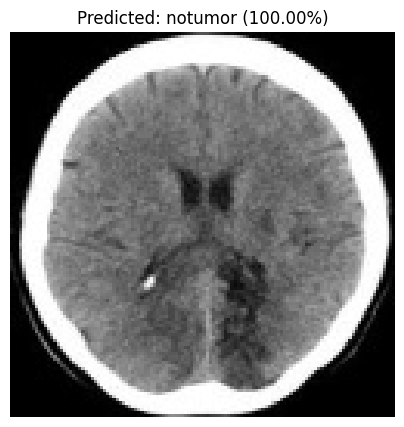

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Predicting sample pituitary image: Te-pi_0086_rgb.jpg

Prediction: pituitary
Confidence: 100.00%
Class probabilities:
  glioma: 0.00%
  meningioma: 0.00%
  notumor: 0.00%
  pituitary: 100.00%


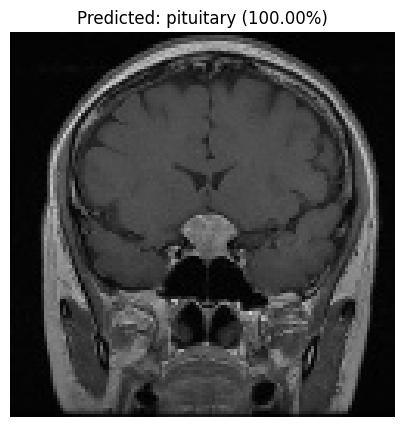

In [ ]:
# For prediction on individual images
import glob
from tensorflow.keras.preprocessing import image

# Get the trained model
model_name, trained_model = trained_models[0]

# Define the target classes for prediction
target_classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Loop through the target classes and predict on one sample image from each
for class_name in target_classes:
    # Find a sample image for the current class
    image_paths = glob.glob(os.path.join(norm_test_path, class_name, '*.jpg'))

    if image_paths:  # Check if the list is not empty
        image_path = image_paths[0]

        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(124, 124))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0  # Normalize

        # Make prediction
        predictions = trained_model.predict(x, verbose=1)
        predicted_class_index = np.argmax(predictions)
        predicted_class = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(predicted_class_index)]
        confidence = predictions[0][predicted_class_index]

        # Print prediction details
        print(f"\nPredicting sample {predicted_class} image: {os.path.basename(image_path)}")
        print(f"\nPrediction: {predicted_class}")
        print(f"Confidence: {confidence:.2%}")
        print("Class probabilities:")

        for class_name_inner, index in train_generator.class_indices.items():
            probability = predictions[0][index]
            print(f"  {class_name_inner}: {probability:.2%}")

        # Display the image with prediction
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class} ({confidence:.2%})")
        plt.axis('off')
        plt.show()
    else:
        print(f"No JPG images found in: {os.path.join(norm_test_path, class_name)}")

the final code with accuracy 95

# **WEP with FLASK :**


In [ ]:
!pip install flask flask_sqlalchemy
!pkill -f ngrok
!pip install pyngrok
!pip install flask flask_sqlalchemy
!mkdir -p templates
!cp /content/r.Html templates/r.Html
!ngrok config add-authtoken 2wDwFsDzgsKZzktkXziZcQ2UKEQ_7m6X5ZZFq3YrxR3mfuXER
!pip install streamlit
!pip install streamlit
!pip install tensorflow
!pip install pillow


cp: cannot stat '/content/r.Html': No such file or directory
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("my_vgg_model.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'my_vgg_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from pyngrok import ngrok
import io
# Load model (make sure it's uploaded to Colab)
model = load_model("my_vgg_model.h5")
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Flask app
app = Flask(__name__)
CORS(app)

@app.route("/predict", methods=["POST"])
def predict():
    if 'file' not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    file = request.files['file']
    print(f"🔍 Received file: {file.filename}")

    try:
        img = image.load_img(io.BytesIO(file.read()), target_size=(124, 124))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) / 255.0

        preds = model.predict(x)
        probs = preds[0].tolist()
        predicted_idx = int(np.argmax(preds))

        return jsonify({
            "predicted_class": class_labels[predicted_idx],
            "confidence": round(float(probs[predicted_idx]), 4),
            "probabilities": {
                label: round(float(probs[i]), 4) for i, label in enumerate(class_labels)
            }
        })

    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return jsonify({"error": str(e)}), 500

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print(f"🚀 Public URL: {public_url}")

# Run Flask app
app.run(port=5000)

In [ ]:
from pyngrok import ngrok
import time

# افتح نفق HTTP على المنفذ 8501
public_url = ngrok.connect(8501, "http")
print(f"🔥 التطبيق يعمل على الرابط: {public_url}")

# شغل Streamlit
!streamlit run app.py &>/content/log.txt &
time.sleep(5)
!tail -n 10 /content/log.txt


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


🔗 رابط تطبيقك: NgrokTunnel: "https://af9c-107-167-179-123.ngrok-free.app" -> "http://localhost:5000"


# ***website***
file:///C:/Users/Dell/Downloads/r%20(2).Html#